# Reinternação
**Esse documento visa sumarizar e extrair os pontos mais importantes de toda a documentação de Reinternação.**


In [1]:
from pprint import pprint as print
from langchain.document_loaders import DirectoryLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import SpacyTextSplitter
from IPython.display import HTML, display
from ipywidgets import widgets, Layout

#setup inicial
embeddings = HuggingFaceEmbeddings()
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())


f:\Desen\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
f:\Desen\Python311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
f:\Desen\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Passo 1. Carregar os documentos ( mude o diretório de acordo com o que quer.)
<i>Se já criou o database de vetores vá direto ao passo 3!</i>

In [6]:
loader = DirectoryLoader('./docs/')
docs = loader.load()

In [7]:
len(docs)

1

<i>Fixando erros de characteres nos documentos</i>

In [3]:
for doc in docs:
	doc.page_content = doc.page_content.encode('ISO-8859-1', errors='ignore') .decode('ISO-8859-1', errors='ignore')

<i>Achar quantos tokens contem todos os textos</i>

In [3]:
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")

tokens = sum(len(encoding.encode(doc.page_content)) for doc in docs)
print(f'Os documentos possuem {tokens} tokens')

'Os documentos possuem 0 tokens'


In [5]:
text_splitter = SpacyTextSplitter(chunk_size=1500, pipeline="pt_core_news_md")
splited_docs = text_splitter.split_documents(docs)
print(f'Agora possuimos {len(splited_docs)} documentos')

'Agora possuimos 88 documentos'


In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=400, chunk_overlap=20)
splited_docs = text_splitter.split_documents(docs)

'Min: 173'
'Avg: 435.95454545454544'
'Max: 548'


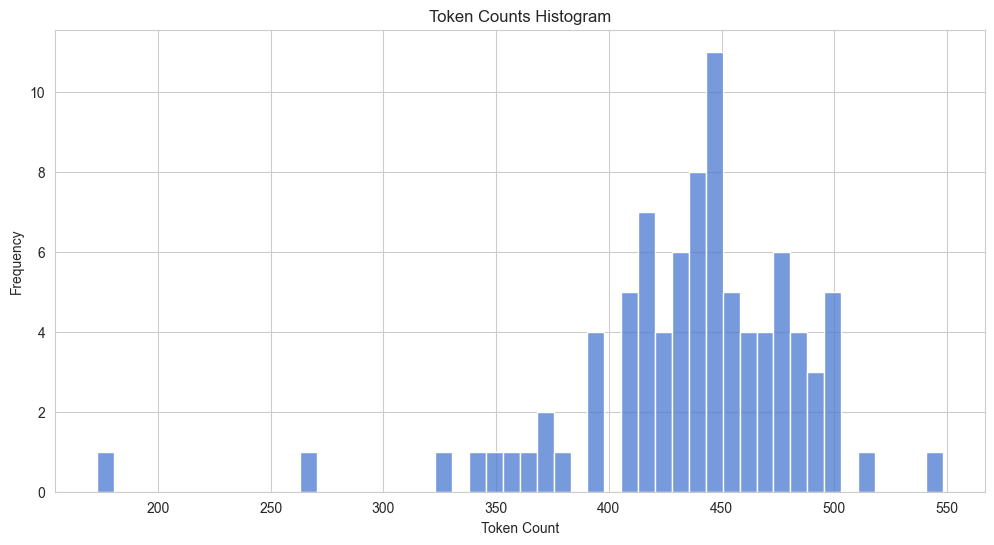

In [6]:
token_counts = [len(encoding.encode(doc.page_content)) for doc in splited_docs]
print(f"Min: {min(token_counts)}")
print(f"Avg: {sum(token_counts) / len(token_counts)}")
print(f"Max: {max(token_counts)}")
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()


## Vetorizando os documentos

In [10]:
db = FAISS.from_documents(splited_docs, embeddings)

## Salvando localmente para acesso rápido da próxima vez

In [11]:
db.save_local(folder_path='./vectors/', index_name='longevity')

## Passo 3: Carregando o índice já salvo

In [2]:
db = FAISS.load_local(folder_path='./vectors/', index_name='reinternacao', embeddings=embeddings)

### Agora podemos procurar na documentação qualquer termo, pergunta usando <code> db.similarity_search </code> command.
**Podemos utilizar tb:**
- <code> db.similarity_search_with_score</code>
- <code>python similarity_search_with_relevance_scores</code>


In [12]:
#db.similarity_search("O que é Pim3?")
answers = db.similarity_search_with_relevance_scores("Medicine 2.0")

In [13]:
answers[0][0].page_content

"(31:21) Today it's 10 percent, effectively. So we've seen a log fold increase in type two diabetes. 100 to 120 million people in the United States are metabolically sick, meaning have metabolic syndrome or pre-diabetes, or type two diabetes outright. So something's not working. And the current system of Medicine 2.0 doesn't really seem equipped to address it.\n\n(31:47) It intervenes late, and by the time it's intervening, it's not really fixing. So this thing I'm proposing, this idea that of course I'm not the first person to suggest, maybe I'm the first person to talk about it this way, is we want to pivot to this newer way of thinking about things which deviates from Medicine 2.\n\n(32:07) 0 in a couple of really important areas. The first is in its timeline. So Medicine 2.0 is largely focused on treating disease. And it's really interesting when I think about it, because it's so obvious that I can't believe I didn't notice it earlier. But when you're in medicine, when you're in me

## Achando respostas para seus problemas

In [14]:
from  langchain.memory import ConversationSummaryBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.llms import OpenAI

memory = ConversationSummaryBufferMemory(llm=OpenAI(), max_token_limit=1000, memory_key="chat_history", return_messages=True)
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.6), db.as_retriever(), memory=memory)

In [15]:
##%%html
css = """
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha3/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-KK94CHFLLe+nY2dmCWGMq91rCGa5gtU4mk92HdvYe+M/SXH301p5ILy+dN9+nJOZ" crossorigin="anonymous">
<style>
    html {data-bs-theme="dark"}
    body{margin-top:20px; 
         background-color: black;
         color: aqua;} 

    .chat-message-left,
    .chat-message-right {
        display: flex;
        color: aqua;
        flex-shrink: 0;
    }

    .chat-message-left {
        margin-right: auto
    }

    .chat-message-right {
        flex-direction: row-reverse;
        margin-left: auto
    }

    .cell-output-ipywidget-background {
        background-color: transparent !important;
    }
    .jp-OutputArea-output {
        background-color: transparent;
    }  
</style>
""" 


In [17]:
from datetime import datetime
def text_eventhandler(*args):
    # Needed bc when we "reset" the text input
    # it fires instantly another event since
    # we "changed" it's value to ""
    if args[0]["new"] == "":
        return

    # Show loading animation
    loading_bar.layout.display = "block"

    # Get question
    question = args[0]["new"]

    # Reset text field
    args[0]["owner"].value = ""

    # Formatting question for output
    q = (
        f'<div class="chat-message-right pb-4"><div><img src="images/bear.png" class="rounded-circle mr-1" width="40" height="40"><div class="text-muted small text-nowrap mt-2">{datetime.now().strftime("%H:%M:%S")}</div></div><div class="flex-shrink-1 bg-dark rounded py-2 px-3 ml-3">'
        + f'<div class="font-weight-bold mb-1">Você</div>{question}</div>'
    )

    # Display formatted question
    output.append_display_data(HTML(q))

    try:
        response = qa({"question": question})
        answer = response["answer"]
        #chat_history.append((question, answer))
    except Exception as e:
        answer = f"<b>Error:</b> {str(e)}"

    # Formatting answer for output
    # Replacing all $ otherwise matjax would format them in a strange way
    answer_formatted = answer.replace('$', r'\$')
    a = (
        f'<div class="chat-message-left pb-4"><div><img src="images/cat.png" class="rounded-circle mr-1" width="40" height="40"><div class="text-muted small text-nowrap mt-2">{datetime.now().strftime("%H:%M:%S")}</div></div><div class="flex-shrink-1 bg-dark rounded py-2 px-3 ml-3">'
        + f'<div class="font-weight-bold mb-1">LLM</div>{answer_formatted}</div>'
    )

    # Turn off loading animation
    loading_bar.layout.display = "none"
    output.append_display_data(HTML(a))


css_widget = widgets.HTML(value=css)
display(css_widget)

in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
output.append_display_data(HTML("<H5 style='color:aqua'>Giuice Chatbot</H5>"))

with open("images/loading.gif", "rb") as file:
    image = file.read()

loading_bar = widgets.Image(
    value=image, format="gif", width="20", height="20", layout={"display": "None"}
)

container = widgets.HBox(
    children=[loading_bar, in_text],
    layout=Layout(display="flex", flex_flow="row")
)

output_container = widgets.HBox(
    children=[output],
    layout=Layout(
        width="100%",
        max_height="500px",
        display="inline-flex",
        flex_flow="column-reverse",
    )
)

# # Apply the dark mode styles to the output_container and container
# output_container.add_class("dark-mode")
# container.add_class("dark-mode")


# Display the containers
display(output_container)
display(container)



HTML(value='\n<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha3/dist/css/bootstrap.min.css" rel=…

## Summarizando o documento par aum entendimento melhor

In [50]:
text = "\n".join(doc.page_content for doc in docs)

In [68]:
summary_splitter = SpacyTextSplitter(chunk_size=3000 , pipeline="pt_core_news_md")
summary_docs = summary_splitter.split_text(text)
len(summary_docs)

21

In [69]:
print([len(encoding.encode(doc)) for doc in summary_docs])

[869,
 911,
 898,
 942,
 876,
 949,
 958,
 926,
 967,
 911,
 936,
 897,
 909,
 904,
 968,
 912,
 931,
 941,
 876,
 837,
 433]


In [72]:
from langchain.prompts import PromptTemplate
map_prompt = """
É um documento das funcionalidades que serão desenvolvidas em um Sprint. Esta seção será colocada entre acentos graves triplos (```)
Seu objetivo é fornecer um resumo desta seção para que os desenvolvedores (c# e front-ends) tenham um entendimento completo do que fazer.

```{text}```
RESUMO COMPLETO, Faça um Título se possível. Saída em PORTUGUÊS Brasileiro:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [78]:
from langchain.chains.summarize import load_summarize_chain

from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
llm = ChatOpenAI( temperature=0.1, max_tokens=1000)
summaries = []
chain = load_summarize_chain(llm=llm, chain_type="map_reduce", map_prompt=map_prompt_template)
summary_docs = [Document(page_content=doc) for doc in summary_docs]
summary = chain.run(summary_docs)

    


In [32]:
print([len(encoding.encode(doc.page_content)) for doc in summaries[0]])

[304, 281, 288, 264, 291, 299, 304, 284, 295, 285, 306, 275, 111]


In [76]:

# The name of the file you want to save
filename = "summaries2.txt"

# Save the list of text to the file
with open(filename, "w", encoding="utf-8") as f:
    for line in summaries:
        f.write(f"{line}\n")
